
# End to End Forecasting Pipeline
In this notebook, you will make forecasts for the M5 dataset choosing the best model for each time series using cross validation.

Outline:

Read data
Forecast the next 28 days using statiscal and deep learning methods
Evaluate the models perfomance on different Windows
Choose the best model for a group of series
Filter the best possible forecast. 

## Installing Libraries

In [ ]:
%%capture
!pip install statsforecast datasetforecast s3fs pyarrow

## Download data

The example uses the [M5 dataset](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf). It consists of `30,490` bottom time series. 

In [ ]:
import pandas as pd

In [ ]:
Y_df = pd.read_parquet('s3://m5-benchmarks/data/train/target.parquet')
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

For simplicity sake we will keep just one category

In [ ]:
Y_df = Y_df.query('unique_id.str.startswith("FOODS_3")')
Y_df['unique_id'] = Y_df['unique_id'].astype(str)

# Basic Plotting

In [ ]:
from statsforecast import StatsForecast

/home/ubuntu/fede/statsforecast/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


MAX incluir explicacion de plot. 

`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Daily data, it would be benefitial to use 7 as seasonality.

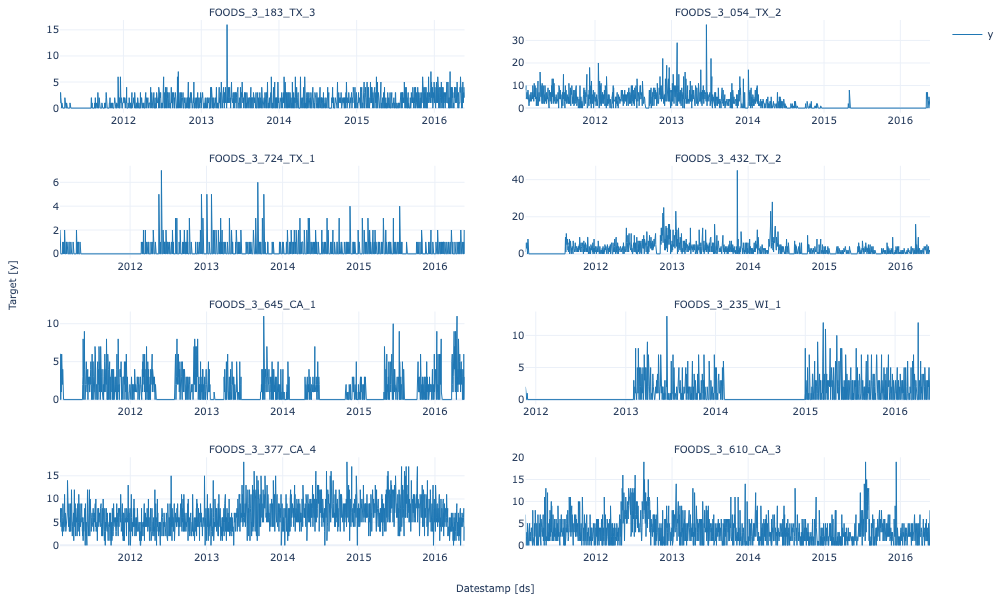

In [ ]:
StatsForecast.plot(Y_df)

# Forecast

## StatsForecast

In [ ]:
from time import time

from statsforecast.models import (
    SeasonalNaive,
    Naive,
    HistoricAverage,
    CrostonOptimized,
    ADIDA,
    IMAPA,
    AutoETS
)

In [ ]:
horizon = 28
models = [
    SeasonalNaive(season_length=7),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=7)
]

In [ ]:
sf = StatsForecast(
    models=models, 
    freq='D', 
    n_jobs=-1,
)

In [ ]:
init = time()
fcst_df = sf.forecast(df=Y_df.groupby('unique_id').tail(28), h=28, level=[90])
end = time()
print(f'Forecast Minutes: {(end - init) / 60}')

Forecast Minutes: 0.8217442909876506


## NeuralForecast

Read from [colab](https://colab.research.google.com/drive/1KnLyGGtJPQlxnTtH3LsHUHzpmZ1-1JwN#scrollTo=65mTrn2gskcR).

In [ ]:
fcst_nf_df = pd.read_parquet('s3://m5-benchmarks/data/forecast-nf.parquet')

In [ ]:
fcst_df = fcst_df.merge(fcst_nf_df, how='left', on=['unique_id', 'ds'])

## Forecast plots

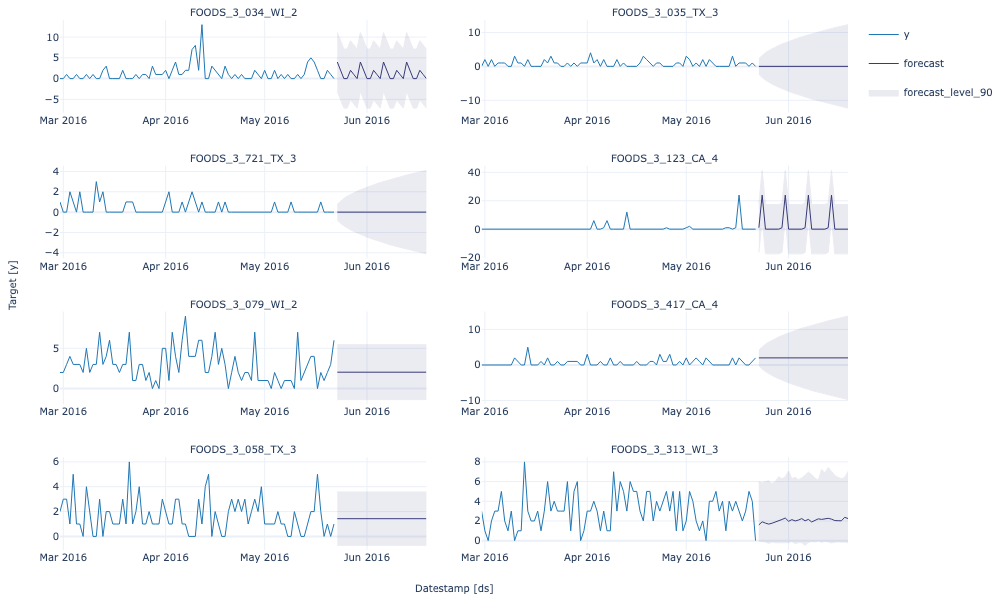

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)

# Perform cross validation

## StatsForecast

In [ ]:
init = time()
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, input_size=28, level=[90])
end = time()
print(f'CV Minutes: {(end - init) / 60}')

/home/ubuntu/fede/statsforecast/statsforecast/ets.py:1039: RuntimeWarning:

divide by zero encountered in divide



CV Minutes: 1.0384724497795106


## NeuralForecast

In [ ]:
cv_nf_df = pd.read_parquet('s3://m5-benchmarks/data/cross-validation-nf.parquet')

## Merge cross validation forecasts

In [ ]:
cv_df = cv_df.merge(cv_nf_df.drop(columns=['y']), how='left', on=['unique_id', 'ds', 'cutoff'])

## Plots CV

In [ ]:
cutoffs = cv_df['cutoff'].unique()

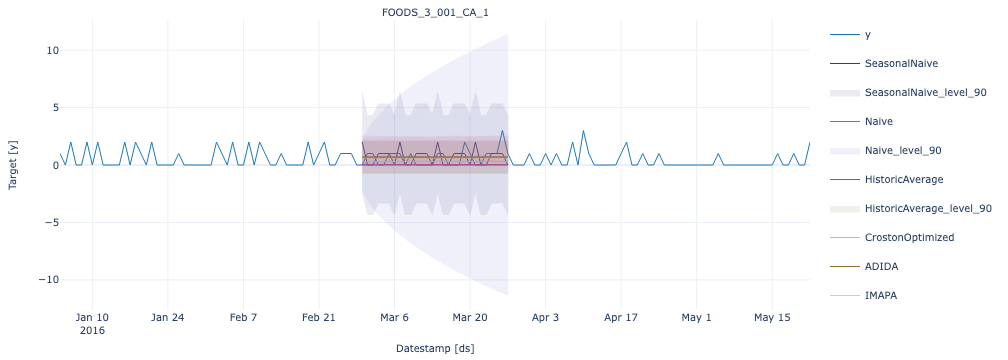

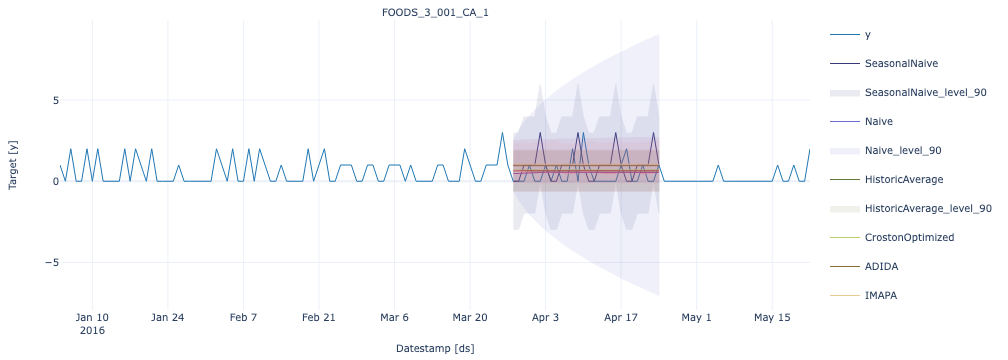

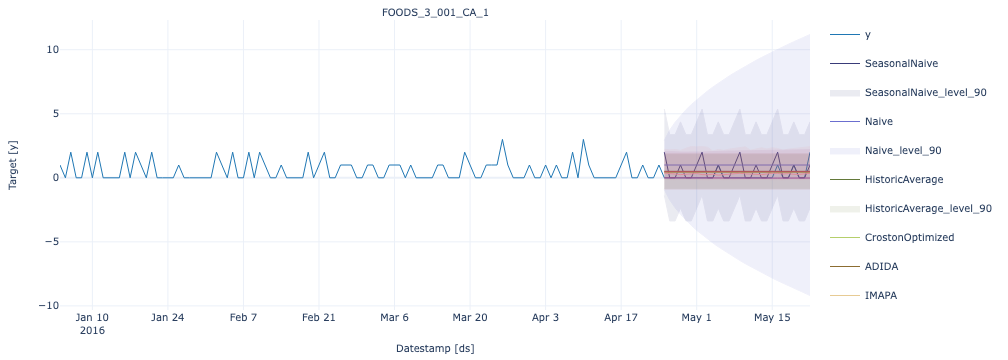

In [ ]:
for cutoff in cutoffs:
    sf.plot(Y_df, 
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
            max_insample_length=28 * 5, 
            unique_ids=['FOODS_3_001_CA_1'])

### Aggregate Demand

In [ ]:
agg_cv_df = cv_df.loc[:,~cv_df.columns.str.contains('hi|lo')].groupby(['ds', 'cutoff']).sum(numeric_only=True).reset_index()
agg_cv_df.insert(0, 'unique_id', 'agg_demand')

In [ ]:
agg_Y_df = Y_df.groupby(['ds']).sum(numeric_only=True).reset_index()
agg_Y_df.insert(0, 'unique_id', 'agg_demand')

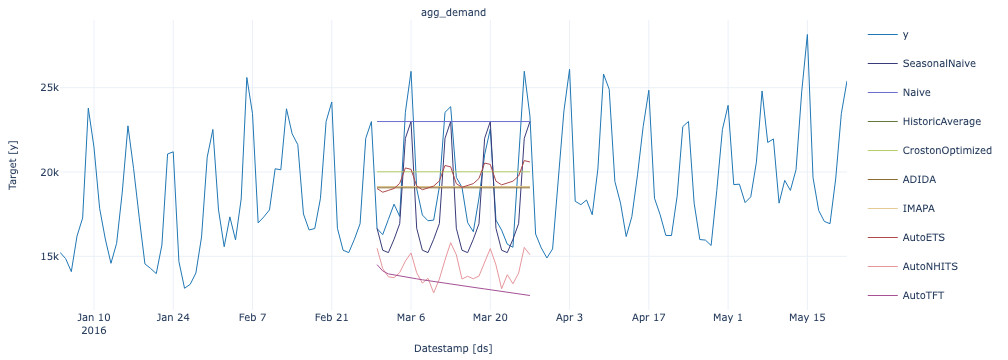

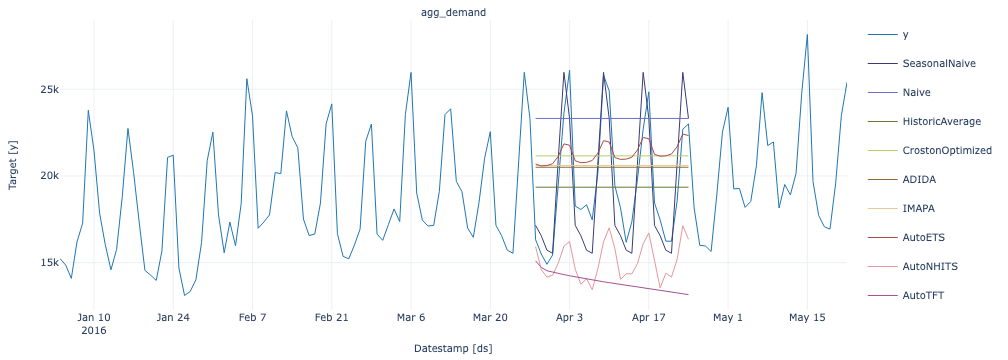

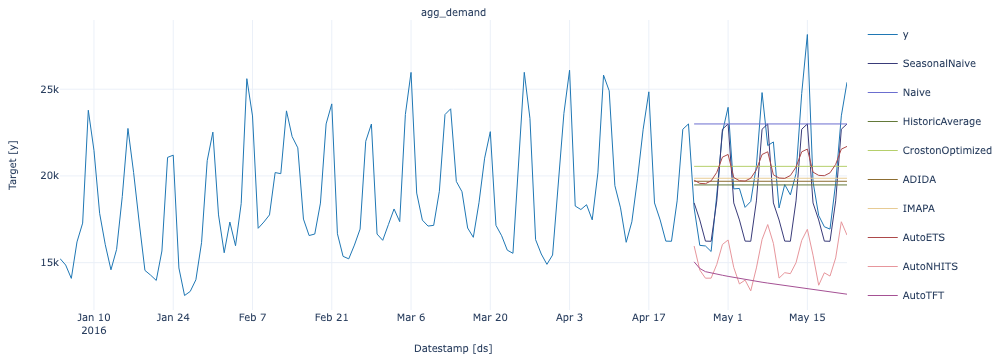

In [ ]:
for cutoff in cutoffs:
    sf.plot(agg_Y_df, 
            agg_cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=28 * 5)

## Evaluation per series and CV window

In [ ]:
from typing import List, Callable

from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine
from datasetsforecast.losses import mse, mae, smape

In [ ]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [ ]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [ ]:
# Fede: introducir cosas

In [ ]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

/home/ubuntu/miniconda/envs/statsforecast/lib/python3.10/site-packages/distributed/dashboard/core.py:20: UserWarning:


Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.0.2.
Continuing without the dashboard.



In [ ]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine=engine, #"dask",
    #engine_conf={"fugue.dask.dataframe.default.partitions": 96},
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

In [ ]:
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

SeasonalNaive      Naive  HistoricAverage  \
cutoff     metric                                              
2016-02-28 mae          1.744289   2.040496         1.516469   
           mse         14.510710  19.080585        10.833869   
           smape       85.202042  87.719086       111.990555   
2016-03-27 mae          1.795973   2.106449         1.533911   
           mse         14.810259  26.044472        10.477906   
           smape       87.407471  89.453247       112.714714   
2016-04-24 mae          1.785983   1.990774         1.541847   
           mse         13.476350  16.234917        10.362277   
           smape       89.238815  90.685867       114.987923   

                   CrostonOptimized       ADIDA       IMAPA     AutoETS  \
cutoff     metric                                                         
2016-02-28 mae             1.581695    1.534496    1.536534    1.620993   
           mse            11.441593   11.158258   11.195016   14.082161   
           smape         111.451569  113.757927  113.675667  113.472603   
2016-03-27 mae             1.624289    1.587990    1.589002    1.702389   
           mse            12.087269   12.131243   12.131521   17.165882   
           smape         112.429581  114.457344  114.316505  114.101669   
2016-04-24 mae             1.612075    1.548616    1.540517    1.611976   
           mse            10.867298   10.424200   10.210446   11.853121   
           smape         114.421707  116.225746  115.819275  115.646690   

                    AutoNHITS     AutoTFT  
cutoff     metric                          
2016-02-28 mae       1.437373    1.471644  
           mse      10.538651   13.366168  
           smape   137.167236  139.280884  
2016-03-27 mae       1.429850    1.484666  
           mse       9.434286   12.615650  
           smape   133.748550  135.919556  
2016-04-24 mae       1.447442    1.501234  
           mse       9.709302   13.046812  
           smape   130.621002  133.509598

### Distribution of errors

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

#### SMAPE

<AxesSubplot: xlabel='error', ylabel='model'>

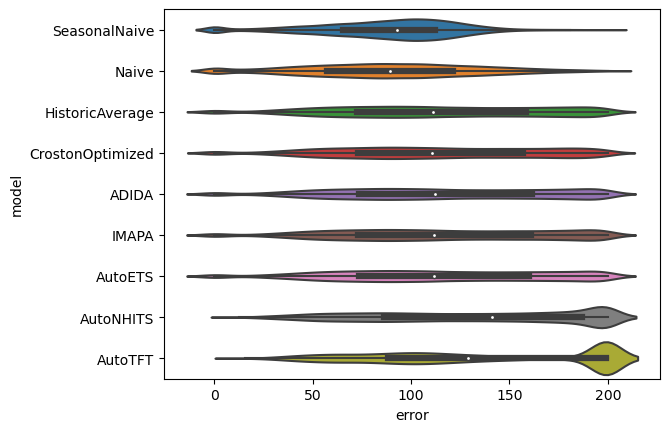

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

#### MAE

<AxesSubplot: xlabel='error', ylabel='model'>

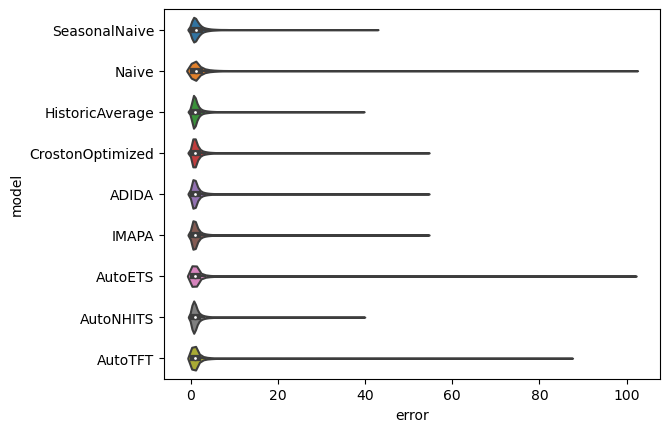

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="mae"'), x='error', y='model')

#### MSE

<AxesSubplot: xlabel='error', ylabel='model'>

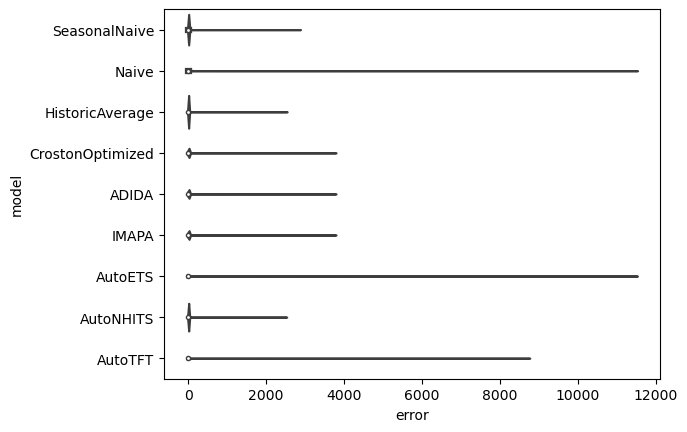

In [ ]:
sns.violinplot(evaluation_df_melted.query('metric=="mse"'), x='error', y='model')

### Best model per series

<AxesSubplot: xlabel='n', ylabel='best_model'>

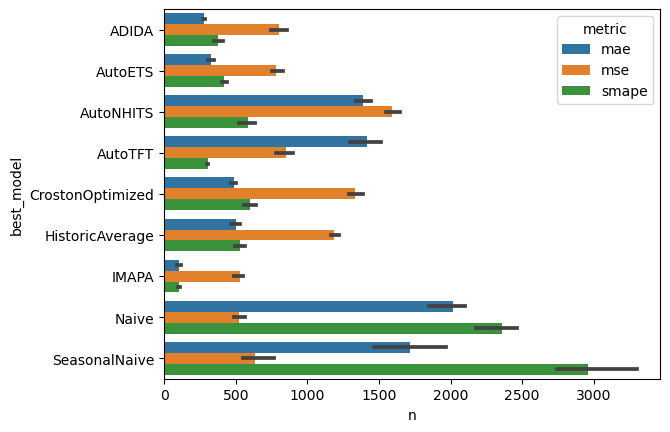

In [ ]:
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')

### Series groups and models 

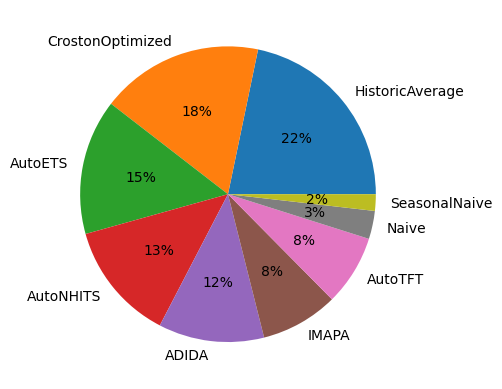

In [ ]:
eval_series_df = evaluation_df.query('metric == "mse"').groupby(['unique_id']).mean(numeric_only=True)
eval_series_df['best_model'] = eval_series_df.idxmin(axis=1)
counts_series = eval_series_df.value_counts('best_model')
plt.pie(counts_series, labels=counts_series.index, autopct='%.0f%%')
plt.show()

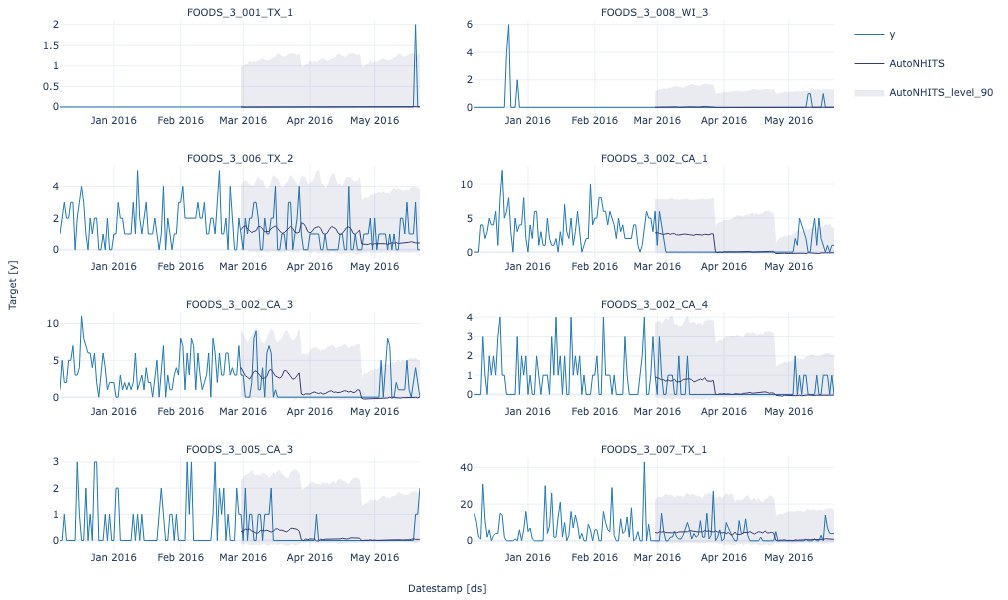

In [ ]:
sf.plot(Y_df, cv_df.drop(columns=['cutoff', 'y']), 
        max_insample_length=28 * 6, 
        models=['AutoNHITS'],
        unique_ids=eval_series_df.query('best_model == "AutoNHITS"').index[:8])

# Choose Forecast

In [ ]:
fcst_df = pd.melt(fcst_df.set_index('unique_id'), id_vars=['ds'], var_name='model', value_name='forecast', ignore_index=False)
fcst_df = fcst_df.join(eval_series_df[['best_model']])
fcst_df[['model', 'pred-interval']] = fcst_df['model'].str.split('-', expand=True, n=1)
fcst_df = fcst_df.query('model == best_model')
fcst_df['name'] = [f'forecast-{x}' if x is not None else 'forecast' for x in fcst_df['pred-interval']]
fcst_df = pd.pivot_table(fcst_df, index=['unique_id', 'ds'], values=['forecast'], columns=['name']).droplevel(0, axis=1).reset_index()

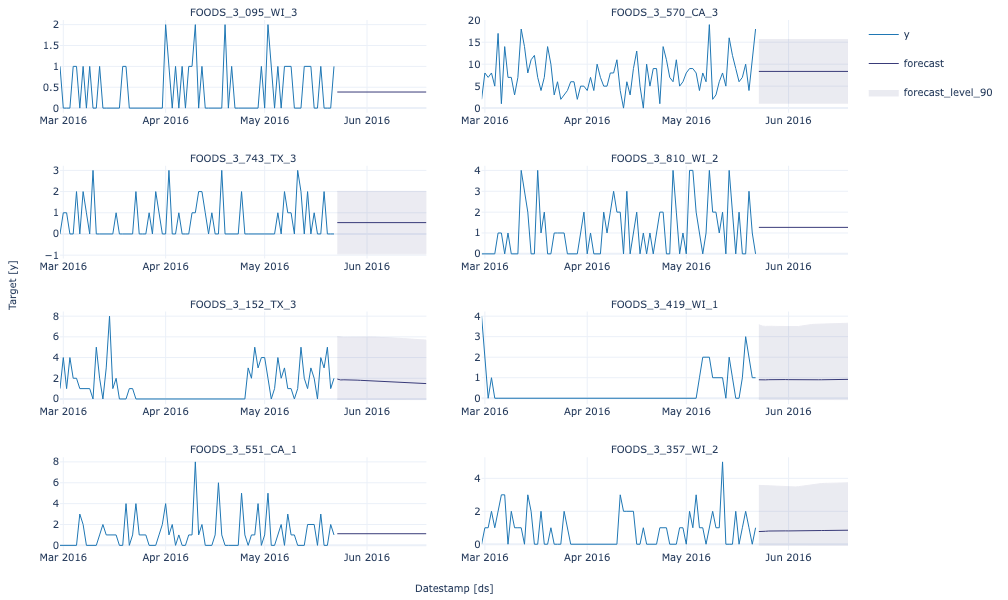

In [ ]:
sf.plot(Y_df, fcst_df, max_insample_length=28 * 3)